### Import Libraries

In [33]:
import pandas as pd
import numpy as np
import math
import tensorflow as tf

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras import Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Input, Dropout, GlobalAveragePooling1D

#### Data Overview

In [34]:
df_data = pd.read_csv('text_clean.csv')

In [35]:
df_data.head()

,text_clean,sentiment
0,warung milik usaha pabrik puluh kenal putih ba...,positive
1,mohon ulama lurus k 212 mmbri hujjah partai di...,neutral
2,lokasi strategis jalan sumatra bandung nyaman ...,positive
3,betapa bahagia unboxing paket barang bagus beli,positive
4,aduh mahasiswa sombong kasih kartu kuning ajar...,negative


In [37]:
df_data[df_data['text_clean'].isnull()]

,text_clean,sentiment


In [38]:
len(df_data['sentiment'])

11000

### Tokenizing data

In [39]:
# Assign Tokenizer() ke tokenizer
tokenizer = Tokenizer()

# Fit text nya ke tokenizer
tokenizer.fit_on_texts(df_data['text_clean'])

# Dibuat sequence
sequence = tokenizer.texts_to_sequences(df_data['text_clean'])

# Assign hasil pad sequence dari data teks untuk training ke dalam variabel X
X = pad_sequences(sequence, maxlen=64) # Pad sequence nya, dibuat maxlen berdasarkan panjang maksimal kata dalam satu baris string di data_df

In [40]:
# Assign data sentimen sebagai target yang mau diprediksi ke dalam variabel y, diubah jadi array
label2id = {'neutral': 0, 'positive': 1, 'negative': 2}
df_data['sentiment'] = df_data['sentiment'].map(label2id) 
y = df_data['sentiment'].values

In [41]:
# Pakai OneHotEncoder
onehot = OneHotEncoder()
y_hot = onehot.fit_transform(y.reshape(-1,1)).toarray() # Balikin lagi bentuknya ke array

In [ ]:
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)
with open('onehot_encode.pickle', 'wb') as f:
    pickle.dump(onehot, f)

In [42]:
print(X.shape)
print(y_hot.shape)

(11000, 64)
(11000, 3)


In [43]:
# Pakai train_test_split buat bagi data train sama data test
X_train, X_test, y_train, y_test = train_test_split(X, y_hot, random_state=123, train_size=0.75, shuffle=True)

In [45]:
y_train

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [46]:
X_train

array([[   0,    0,    0, ..., 5511,  713, 1953],
       [   0,    0,    0, ..., 1117,  491, 4841],
       [   0,    0,    0, ...,  350,  559, 1778],
       ...,
       [   0,    0,    0, ...,  112, 1781,   61],
       [   0,    0,    0, ...,  590,  150,   10],
       [   0,    0,    0, ...,   39,   27,  232]])

In [51]:
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (8250, 64)
X_test: (2750, 64)
y_train: (8250, 3)
y_test: (2750, 3)


### Model NN

In [52]:
# Kita pakai keras sequential untuk modelnya
model = tf.keras.Sequential([

    # Pakai layer embedding, isinya max_features, output_dim, dan input_shape
    tf.keras.layers.Embedding(15000, 128, input_shape=(64,)),

    # Layer GlobalAveragePooling1D ngubah input biar sesuai sama output
    # tf.keras.layers.GlobalAveragePooling1D(),

    # Layer Flatten biar data inputnya dikalikan sama output_dim
    tf.keras.layers.Flatten(),

    #Layer Dense
    tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Assign loss function yang mau dipakai ke dalam variabel loss_fn
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

# Assign optimizer yang mau dipakai ke dalam variabel (sgd karena pakai optimizer SGD), learning rate bisa ditunning untuk cari hasil yg lebih bagus
sgd = tf.keras.optimizers.SGD(learning_rate=0.0005)

# Bikin kondisi untuk early stopping berdasarkan parameter yang dimonitor
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='min',
    verbose=1,
    patience=180,
    restore_best_weights=True)

# Compile model
model.compile(loss=loss_fn, optimizer=sgd, metrics=['accuracy'])

# Menampilkan summary dari model yang udah dibuah
model.summary()

c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 64, 128)        │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,979,139 (11.36 MB)

 Trainable params: 2,979,139 (11.36 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# Assign nilai epoch ke dalam n_epoch, gak diassign pun gak apa apa, langsung masuk di model fit
n_epochs = 200

# Simpan hasil model fit nya ke dalam history, supaya bisa pakai hasil training yang paling bagus setelah proses training
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_test, y_test), callbacks=[es], batch_size=64)

Epoch 1/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.3729 - loss: 1.0965 - val_accuracy: 0.5764 - val_loss: 1.0775
Epoch 2/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5833 - loss: 1.0736 - val_accuracy: 0.5902 - val_loss: 1.0571
Epoch 3/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5739 - loss: 1.0547 - val_accuracy: 0.5905 - val_loss: 1.0393
Epoch 4/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5845 - loss: 1.0376 - val_accuracy: 0.5905 - val_loss: 1.0231
Epoch 5/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5839 - loss: 1.0230 - val_accuracy: 0.5905 - val_loss: 1.0080
Epoch 6/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5840 - loss: 1.0093 - val_accuracy: 0.5905 - val_loss: 0.9939
Epoch 7/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5850 - loss: 0.9946 - val_accuracy: 0.5905 - val_loss: 0.9806
Epoch 8/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5823 - loss: 0.9833 - 

In [54]:
# Panggil history dari model fitting tadi pakai fungsi history
result = history.history

# Define num_epochs buat keperluan visualisasi
num_epochs = np.arange(0, len(result['accuracy']))

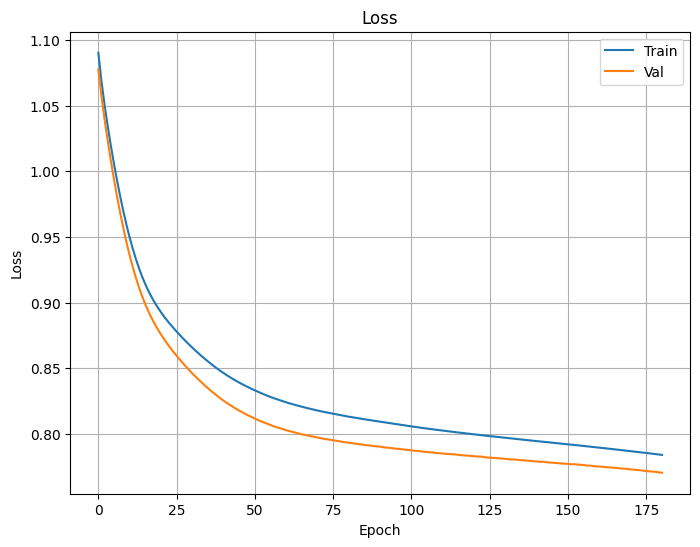

In [55]:
# Visualisasi hasil training dan evaluasinya
plt.figure(figsize=(8,6))
plt.title('Loss')
plt.plot(num_epochs, result['loss'])
plt.plot(num_epochs, result['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])
plt.grid()
plt.show()

In [ ]:
# Visualisasi hasil training dan evaluasinya
plt.figure(figsize=(8,6))
plt.title('Accuracy')
plt.plot(num_epochs, result['accuracy'])
plt.plot(num_epochs, result['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'])
plt.grid()
plt.show()

In [56]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

y_pred_test = model.predict(X_test)

y_pred = y_pred_test.argmax(axis=1)
y_test_pred = y_test.argmax(axis=1)
print("Testing selesai")
print(classification_report(y_pred, y_test_pred, zero_division=0.0))

accuracy = accuracy_score(y_pred, y_test_pred)
print('Accuracy Score SGD (0.0005) :', round(accuracy, 2))

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.84      0.62      0.71      2219
           2       0.25      0.41      0.31       531

    accuracy                           0.58      2750
   macro avg       0.37      0.34      0.34      2750
weighted avg       0.73      0.58      0.64      2750

Accuracy Score SDG (0.0005) : 0.58


In [ ]:
model.save('NN.h5')

### Prediction test

In [62]:
import re
def cleansing(text):
    text = re.sub(r'\\t|\\n|\\u', ' ', text) #Menghapus karakter khusus seperti tab, baris baru, karakter Unicode, dan backslash.
    text = re.sub(r"https?:[^\s]+", ' ', text)  # Menghapus http / https
    text = re.sub(r'(\b\w+)-\1\b', r'\1', text)
    text = re.sub(r'[\\x]+[a-z0-9]{2}', '', text)  # Menghapus karakter yang dimulai dengan '\x' diikuti oleh dua karakter huruf atau angka
    # text = re.sub(r'(\d+)', r' \1 ', text)  # Memisahkan angka dari teks
    text = re.sub(r'[^a-zA-Z]+', ' ', text)  # Menghapus karakter kecuali huruf, dan spasi
    text = re.sub(r'\brt\b|\buser\b', ' ', text) # Menghapus kata-kata 'rt' dan 'user'
    text = text.lower()
    return text

label = ['negative', 'neutral', 'positive']

original_text = 'BodOH banget jadi orang'
cleaned_text = cleansing(original_text)
text_sequence = tokenizer.texts_to_sequences([cleaned_text])
text_padded = pad_sequences(text_sequence, maxlen=64)

result = model.predict(text_padded)[0]
predicted_class = np.argmax(result)
predicted_label = label[predicted_class]

print('Sentiment :')
print(predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Sentiment :
positive
